In [1]:
from __future__ import print_function
import os, sys, urllib, gzip, matplotlib
sys.setrecursionlimit(10000)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cPickle as pickle

import theano.tensor as T
import theano

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import DropoutLayer, BatchNormLayer, ParametricRectifierLayer
from lasagne.layers import get_output, get_output_shape, get_all_layers, get_all_params
from lasagne.layers import get_all_param_values, set_all_param_values
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import MaxPool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax, sigmoid, rectify, linear
from lasagne.nonlinearities import leaky_rectify, tanh, very_leaky_rectify
from lasagne.init import Constant, Normal, Uniform, GlorotNormal
from lasagne.init import GlorotUniform, HeNormal, HeUniform

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, CuDNN 4007)


In [32]:
# load mnist data
fname = '/home/peter/Data/mnist/mnist.pkl.gz'
f = gzip.open(fname, 'rb')
train_set, valid_set, test_set = pickle.load(f)
f.close()
X, y = train_set

# reshape from (50000, 784) to 4D tensor (50000, 1, 28, 28)
X = np.reshape(X, (-1, 1, 28, 28))

X = X.astype('float32')
chan = X.shape[1]
width = X.shape[2]
height = X.shape[3]


shape = (None, chan, width, height)
num_labels = max(y)+1

def batch_generator(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('float32')


In [3]:

# build model
input_var = T.tensor4('input')
l_in = layers.InputLayer(shape=shape, input_var=input_var, name='input')

l_conv1 = layers.Conv2DLayer(l_in, num_filters=50, filter_size=(5,5), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='same', name='conv1')
l_bias1 = layers.BiasLayer(l_conv1, b=init.Constant(0.05))
l_nonlin1 = layers.NonlinearityLayer(l_bias1, nonlinearity=nonlinearities.rectify)

l_conv2 = layers.Conv2DLayer(l_nonlin1, num_filters=35, filter_size=(3,3), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='same', name='conv1')
l_bias2 = layers.BiasLayer(l_conv2, b=init.Constant(0.05))
l_nonlin2 = layers.NonlinearityLayer(l_bias2, nonlinearity=nonlinearities.rectify)
l_pool2 = layers.MaxPool2DLayer(l_nonlin2, pool_size=(2,2))

l_conv3 = layers.Conv2DLayer(l_pool2, num_filters=20, filter_size=(3,3), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='same', name='conv1')
l_bias3 = layers.BiasLayer(l_conv3, b=init.Constant(0.05))
l_nonlin3 = layers.NonlinearityLayer(l_bias3, nonlinearity=nonlinearities.rectify)
l_pool3 = layers.MaxPool2DLayer(l_nonlin3, pool_size=(2,2))

l_dense4 = layers.DenseLayer(l_pool3,  num_units=10, W=init.GlorotUniform(), 
                             nonlinearity=None, b=None)
l_bias4 = layers.BiasLayer(l_dense4, b=init.Constant(0.0))
l_nonlin4 = layers.NonlinearityLayer(l_bias4, nonlinearity=nonlinearities.softmax)

l_enc = layers.NonlinearityLayer(l_nonlin4, nonlinearity=None)

l_dec5 = layers.InverseLayer(l_enc, l_dense4, name='decode')
l_bias5 = layers.BiasLayer(l_dec5, init.Constant(0.0))
l_nonlin5 = layers.NonlinearityLayer(l_bias5, nonlinearity=nonlinearities.sigmoid)

l_depool6 = layers.InverseLayer(l_nonlin5, l_pool3, name='depool')
l_dec6 = layers.InverseLayer(l_depool6, l_conv3, name='decode')
l_bias6 = layers.BiasLayer(l_dec6, init.Constant(0.05))
l_nonlin6 = layers.NonlinearityLayer(l_bias6, nonlinearity=nonlinearities.rectify)

l_depool7 = layers.InverseLayer(l_nonlin6, l_pool2, name='depool')
l_deconv7 = layers.InverseLayer(l_depool7, l_conv2, name='deconv')
l_bias7 = layers.BiasLayer(l_deconv7, init.Constant(0.05))
l_nonlin7 = layers.NonlinearityLayer(l_bias7, nonlinearity=nonlinearities.rectify)

l_deconv8 = layers.InverseLayer(l_nonlin7, l_conv1, name='deconv')
l_bias8 = layers.BiasLayer(l_deconv8, init.Constant(0.05))
l_out = layers.NonlinearityLayer(l_bias8, nonlinearity=nonlinearities.rectify)


prediction = get_output(l_out)
train_loss = objectives.squared_error(prediction, input_var)
train_loss = train_loss.mean()

valid_prediction = get_output(l_out, deterministic=True)
valid_loss = objectives.squared_error(valid_prediction, input_var)
valid_loss = valid_loss.mean()

params = get_all_params(l_out, trainable=True)
update_op = updates.adam(train_loss, params)

train_function = theano.function([input_var], train_loss, updates=update_op)
valid_function = theano.function([input_var], valid_loss)


In [5]:
batch_size = 128

num_train_batches = len(X) // batch_size
train_batches = batch_generator(X, y, batch_size)

n_epochs = 5
for e in range(n_epochs):
    for index in range(num_train_batches):
        X_batch, y_batch = next(train_batches)
        train_loss = train_function(X_batch)
    print("train: %f" % train_loss)


train: 0.001606
train: 0.001367
train: 0.001468
train: 0.001239
train: 0.001414


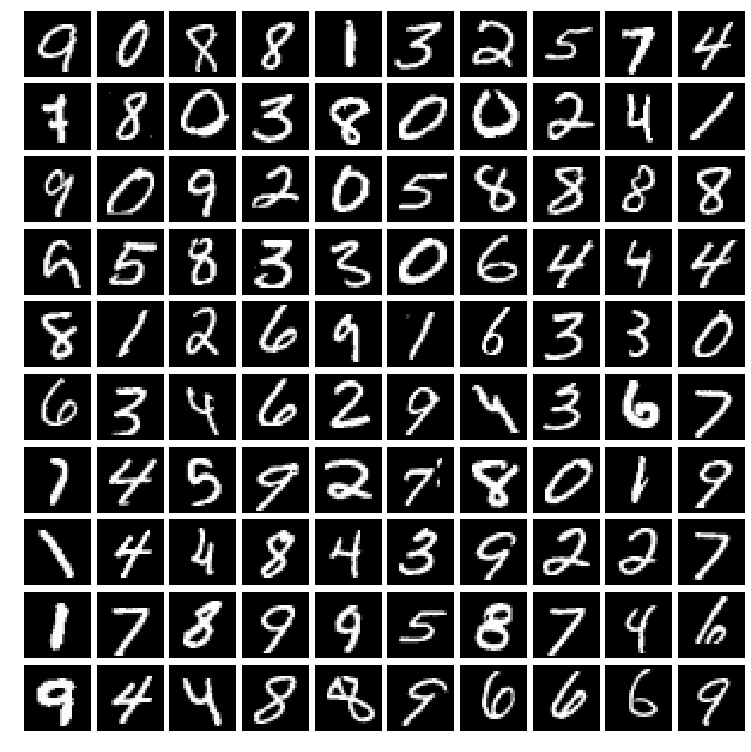

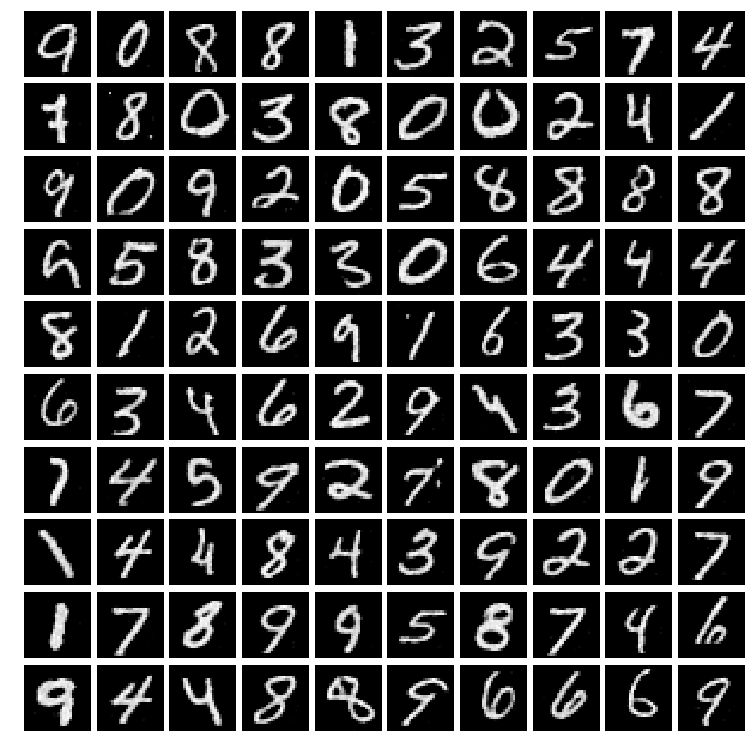

In [6]:
full = theano.function([input_var], layers.get_output(l_out), allow_input_downcast=True)
encode = theano.function([input_var], layers.get_output(l_enc), allow_input_downcast=True)

target_var = T.dmatrix('codes')
out_expr = layers.get_output(l_out, {l_enc:target_var})
fn = theano.function([target_var, l_in.input_var], out_expr, allow_input_downcast=True)


width = 10
height = 10
offset = 3000

index = range(offset, offset+width*height)

plt.figure(figsize = (height,width))
fig = plt.gcf()
fig.set_size_inches(100, 100, forward=True)
gs = mpl.gridspec.GridSpec(height, width)
gs.update(wspace=0.1, hspace=0.1, left=0.1, right=0.2, bottom=0.1, top=0.2) 
for i in range(width*height):
    orig_image = np.expand_dims(X[index[i]], axis=0) 
    plt.subplot(gs[i])
    plt.imshow(np.squeeze(orig_image), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.show()


plt.figure(figsize = (height,width))
fig = plt.gcf()
fig.set_size_inches(100, 100, forward=True)
gs = mpl.gridspec.GridSpec(height, width)
gs.update(wspace=0.1, hspace=0.1, left=0.1, right=0.2, bottom=0.1, top=0.2) 
for i in range(width*height):
    orig_image = np.expand_dims(X[index[i]], axis=0) 
    code = encode(orig_image)
    encode_image = fn(code, orig_image)
    plt.subplot(gs[i])
    plt.imshow(np.squeeze(encode_image), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.show()



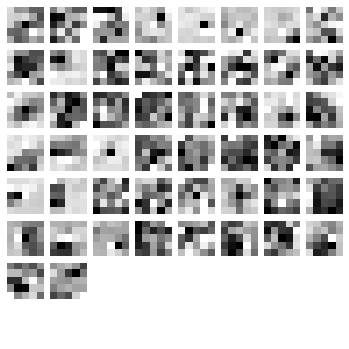

In [7]:

def plot_conv_weights(layer, figsize=(6, 6)):
    """nolearn's plot the weights of a specific layer"""

    W =  np.squeeze(layer.W.get_value())
    shape = W.shape
    nrows = np.ceil(np.sqrt(shape[0])).astype(int)
    ncols = nrows

    figs, axes = plt.subplots(nrows, ncols, figsize=figsize,frameon=False)

    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

    for i, ax in enumerate(axes.ravel()):
        if i >= shape[0]:
            break
        im = ax.imshow(W[i], cmap='gray', interpolation='nearest')

    return figs, axes


figs, axes = plot_conv_weights(l_conv1)



In [36]:
shape

(None, 10)

In [38]:
from lasagne.layers import get_output_shape
shape = get_output_shape(l_pool3)

encode = theano.function([input_var], layers.get_output(l_pool3), allow_input_downcast=True)

batch_size = 128
num_batches = len(X) // batch_size
val = np.zeros(shape[1]*shape[2]*shape[3])
label = np.zeros(1)
index = np.zeros(1)
for i in range(num_batches):
    index = np.vstack([index, np.reshape(np.arange(i*batch_size,(i+1)*batch_size), (batch_size,-1) )])

    code = encode(X[i*batch_size:(i+1)*batch_size])
    val = np.vstack([val, np.reshape(code, (batch_size,-1))])
    label = np.vstack([label, np.reshape(y[i*batch_size:(i+1)*batch_size], (batch_size,-1))])
val.shape
label = np.squeeze(label)
index = np.squeeze(index)

In [10]:
from tsne import bh_sne

# perform t-SNE embedding
#vis_data = bh_sne(val)
X2 = np.reshape(val, (val.shape[0],-1))
vis_data = bh_sne(X2.astype(float))


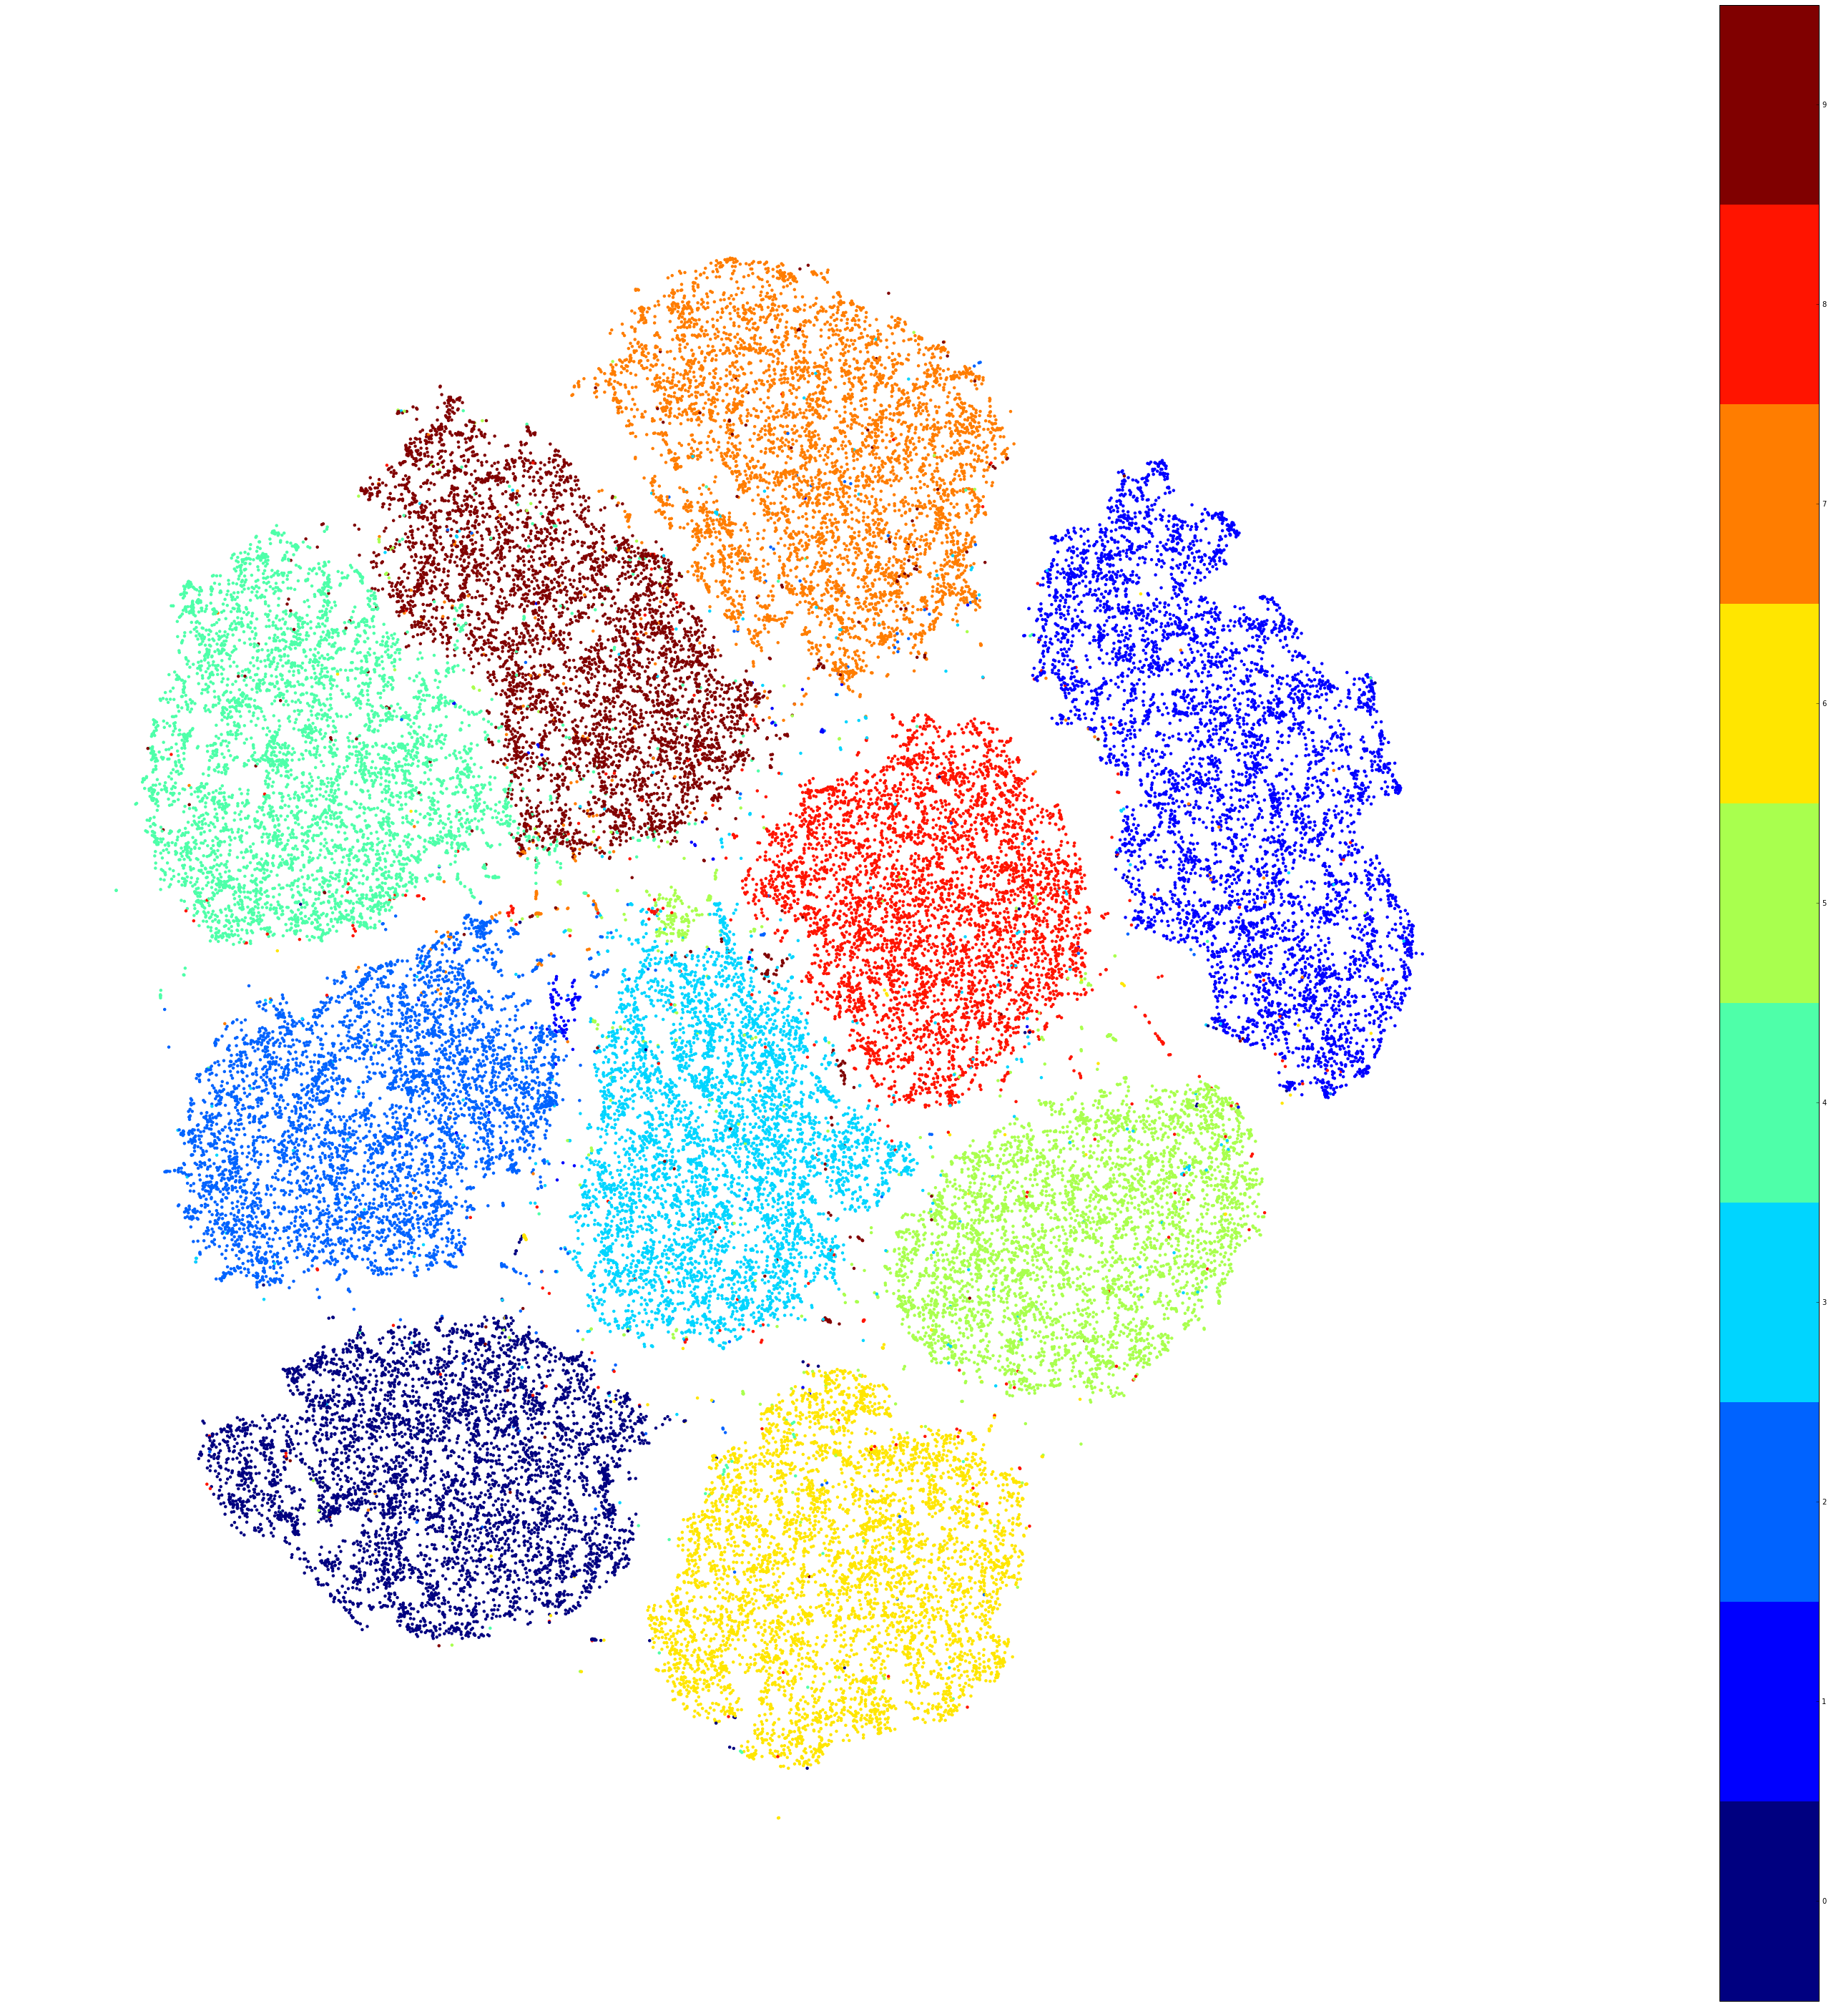

In [13]:
# plot the result
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]


plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(50, 50, forward=True)
plt.scatter(vis_x, vis_y, c=label[0:len(X2)+1], cmap=plt.cm.get_cmap("jet", 10),  edgecolor = 'none')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.axis('off')
plt.show()

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


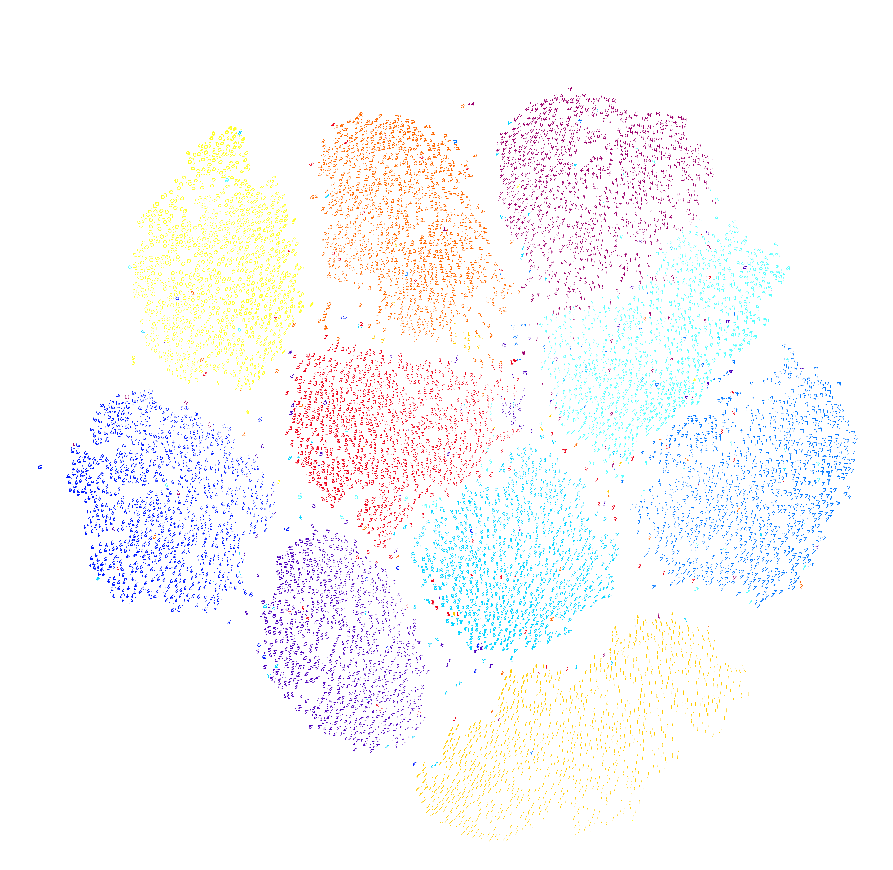

In [27]:
from scipy.misc import imresize
from matplotlib import cm

scale = np.round(256/num_labels)
colormap = cm.jet(range(20,num_labels*scale, scale))

# rescale embedding positions [0, 1]
MIN = np.min(vis_data)
data = vis_data - MIN
MAX = np.max(data)
data = data/MAX

# create canvas
canvas_size = 4000
canvas = np.zeros((canvas_size, canvas_size, 3)).astype(np.uint8)
image_size = 28
scale = canvas_size-image_size

# embed images onto canvas
num_samples = 20000
for i in range(num_samples):
    pos = np.ceil(data[i,:]*scale).astype(int)
    downsample_img =imresize(np.squeeze(X[index[i]]),(image_size,image_size))
    
    for j in range(3):
        canvas[pos[0]:pos[0]+image_size,pos[1]:pos[1]+image_size,j] = downsample_img*colormap[label[i]][j]
            
    
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(15, 15, forward=True)
plt.imshow(np.invert(canvas), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()

In [40]:
from lasagne.layers import get_output_shape
shape = get_output_shape(l_enc)

encode = theano.function([input_var], layers.get_output(l_enc), allow_input_downcast=True)

batch_size = 128
num_batches = len(X) // batch_size
val = np.zeros(10)
label = np.zeros(1)
index = np.zeros(1)
for i in range(num_batches):
    index = np.vstack([index, np.reshape(np.arange(i*batch_size,(i+1)*batch_size), (batch_size,-1) )])

    code = encode(X[i*batch_size:(i+1)*batch_size])
    val = np.vstack([val, np.reshape(code, (batch_size,-1))])
    label = np.vstack([label, np.reshape(y[i*batch_size:(i+1)*batch_size], (batch_size,-1))])
val.shape
label = np.squeeze(label)
index = np.squeeze(index)

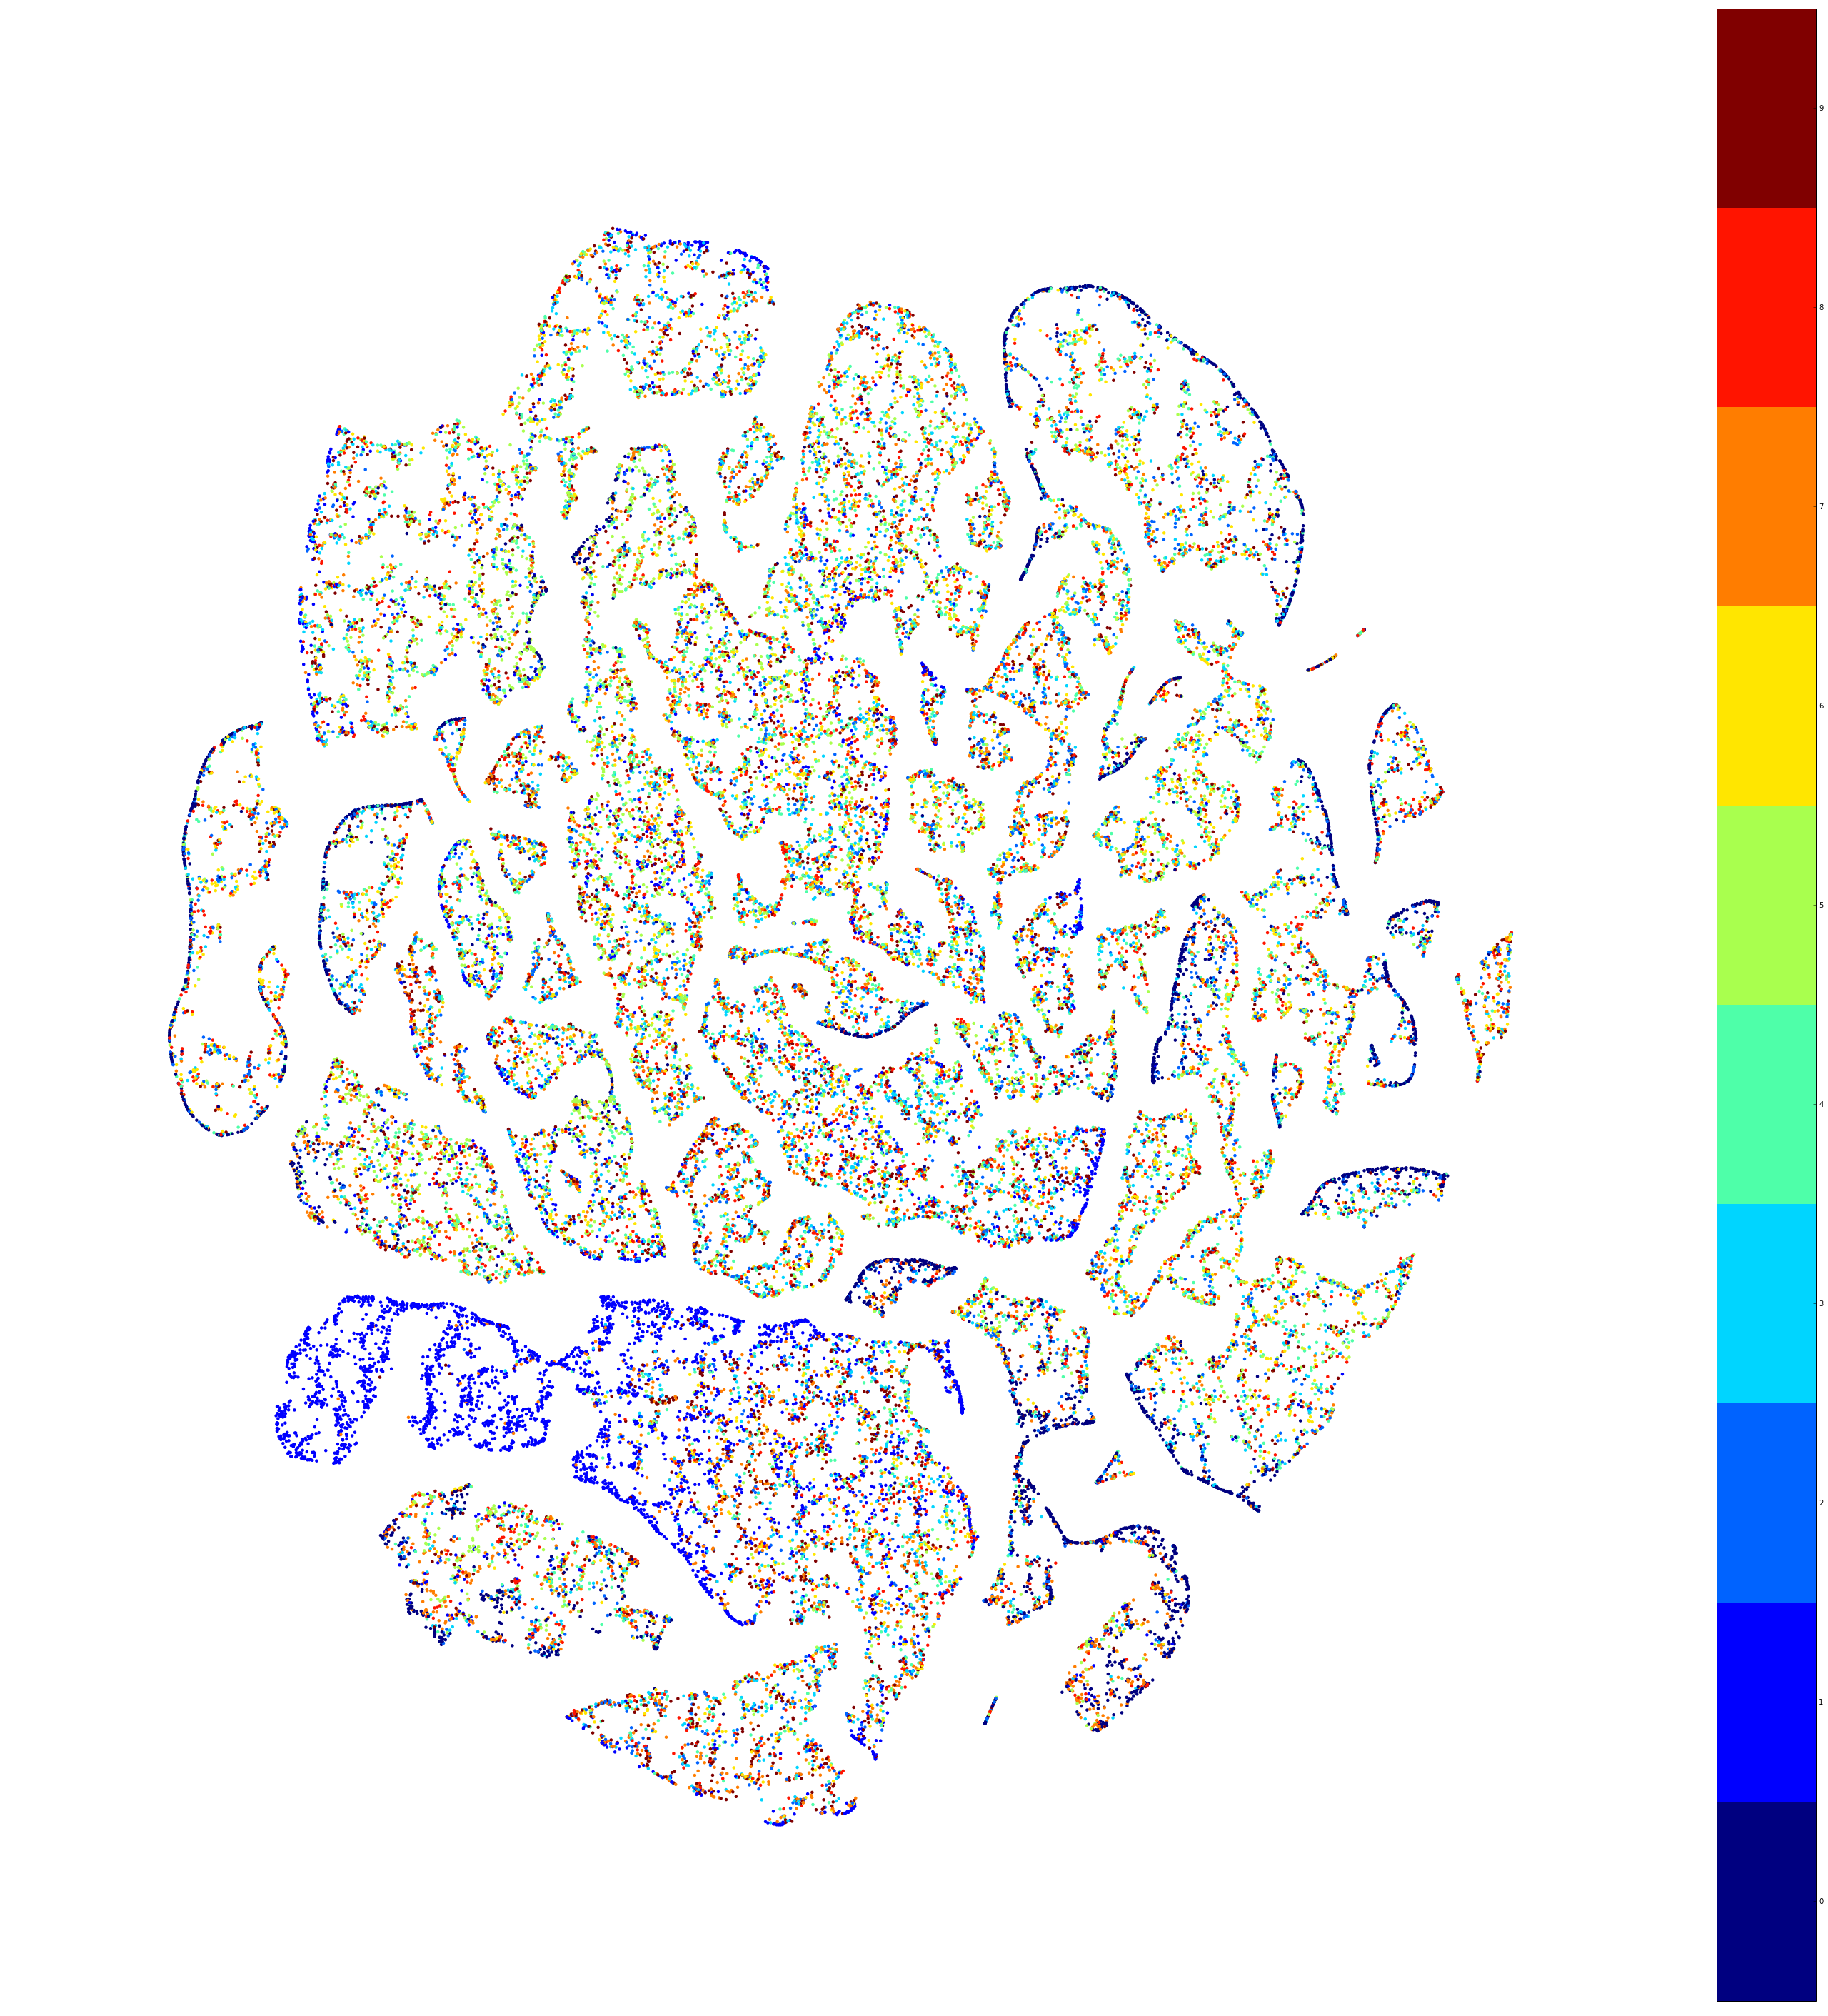

In [41]:
X2 = np.reshape(val, (val.shape[0],-1))
vis_data = bh_sne(X2.astype(float))
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(50, 50, forward=True)
plt.scatter(vis_x, vis_y, c=label[0:len(X2)+1], cmap=plt.cm.get_cmap("jet", 10),  edgecolor = 'none')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.axis('off')
plt.show()

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


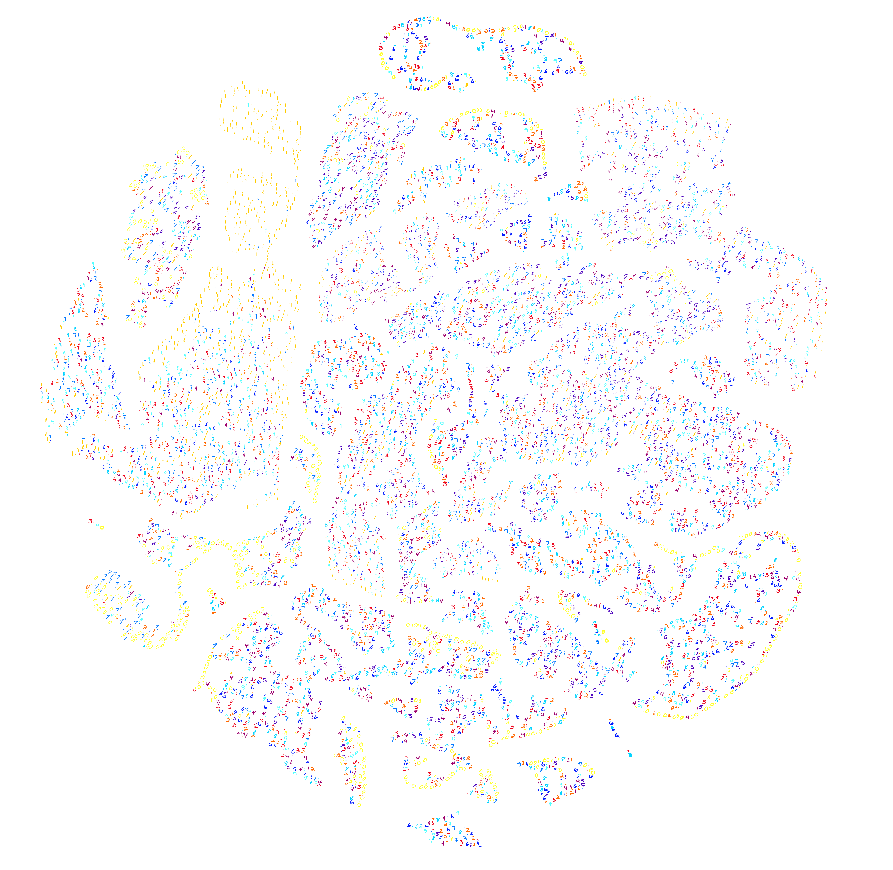

In [42]:
from scipy.misc import imresize
from matplotlib import cm

scale = np.round(256/num_labels)
colormap = cm.jet(range(20,num_labels*scale, scale))

# rescale embedding positions [0, 1]
MIN = np.min(vis_data)
data = vis_data - MIN
MAX = np.max(data)
data = data/MAX

# create canvas
canvas_size = 4000
canvas = np.zeros((canvas_size, canvas_size, 3)).astype(np.uint8)
image_size = 28
scale = canvas_size-image_size

# embed images onto canvas
num_samples = 20000
for i in range(num_samples):
    pos = np.ceil(data[i,:]*scale).astype(int)
    downsample_img =imresize(np.squeeze(X[index[i]]),(image_size,image_size))
    
    for j in range(3):
        canvas[pos[0]:pos[0]+image_size,pos[1]:pos[1]+image_size,j] = downsample_img*colormap[label[i]][j]
            
    
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(15, 15, forward=True)
plt.imshow(np.invert(canvas), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()

In [ ]:
from tsne import bh_sne

# perform t-SNE embedding
#vis_data = bh_sne(val)
X2 = np.reshape(X, (50000,-1))
vis_data = bh_sne(X2.astype(float))

In [ ]:
# plot the result
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]


plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(50, 50, forward=True)
plt.scatter(vis_x, vis_y, c=y[0:len(X2)], cmap=plt.cm.get_cmap("jet", 10),  edgecolor = 'none')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.axis('off')
plt.show()


In [ ]:
from scipy.misc import imresize
from matplotlib import cm

scale = np.round(256/num_labels)
colormap = cm.hsv(range(0,num_labels*scale, scale))

# rescale embedding positions [0, 1]
MIN = np.min(vis_data)
data = vis_data - MIN
MAX = np.max(data)
data = data/MAX

# create canvas
canvas_size = 2000
canvas = np.zeros((canvas_size, canvas_size, 3)).astype(np.uint8)
image_size = 28
scale = canvas_size-image_size

# embed images onto canvas
num_samples = 10000
for i in range(num_samples):
    pos = np.ceil(data[i,:]*scale).astype(int)
    downsample_img =imresize(np.squeeze(X[i]),(image_size,image_size))
    
    for j in range(3):
        canvas[pos[0]:pos[0]+image_size,pos[1]:pos[1]+image_size,j] = downsample_img*colormap[y[i]][j]
            
    
plt.figure(figsize = (10,10))
fig = plt.gcf()
fig.set_size_inches(15, 15, forward=True)
plt.imshow(np.invert(canvas), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()

In [ ]:
all_params = get_all_param_values(l_nonlin4)

In [ ]:
# build model
input_var = T.tensor4('input')

l_in = layers.InputLayer(shape=shape, input_var=input_var, name='input')
l_conv1 = layers.Conv2DLayer(l_in, num_filters=100, filter_size=(3,3), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='valid', name='conv1')
#l_norm1 = layers.BatchNormLayer(l_conv1)
l_bias1 = layers.BiasLayer(l_conv1, b=init.Constant(0.05))
l_nonlin1 = layers.NonlinearityLayer(l_bias1, nonlinearity=nonlinearities.rectify)
#l_pool1 = layers.MaxPool2DLayer(l_nonlin1, pool_size=(2,2))

#l_conv2 = layers.Conv2DLayer(l_pool1, num_filters=150, filter_size=(3,3), W=init.GlorotUniform(), 
#                             nonlinearity=None, b=None, pad='same', name='conv1')
#l_bias2 = layers.BiasLayer(l_conv2, b=init.Constant(0.05))
#l_nonlin2 = layers.NonlinearityLayer(l_bias2, nonlinearity=nonlinearities.rectify)
#l_pool2 = layers.MaxPool2DLayer(l_nonlin2, pool_size=(2,1))
"""
l_conv3 = layers.Conv2DLayer(l_pool1, num_filters=100, filter_size=(3,3), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='same', name='conv1')
l_norm3 = layers.BatchNormLayer(l_conv3)
l_bias3 = layers.BiasLayer(l_norm3, b=init.Constant(0.05))
l_nonlin3 = layers.NonlinearityLayer(l_bias3, nonlinearity=nonlinearities.rectify)
l_pool3 = layers.MaxPool2DLayer(l_nonlin3, pool_size=(2,2))
# l_drop3 = layers.DropoutLayer(l_pool3, p=0.3)
"""
l_dense3 = layers.DenseLayer(l_nonlin1, num_units=100, W=init.GlorotUniform(), name='inter')
l_bias3 = layers.BiasLayer(l_dense3, init.Constant(0.0))
l_nonlin3 = layers.NonlinearityLayer(l_bias3, nonlinearity=nonlinearities.tanh)

l_dense4 = layers.DenseLayer(l_nonlin3, num_units=50, W=init.GlorotUniform(), name='inter')
l_bias4 = layers.BiasLayer(l_dense4, init.Constant(0.0))
l_nonlin4 = layers.NonlinearityLayer(l_bias4, nonlinearity=nonlinearities.softmax)

l_enc = layers.NonlinearityLayer(l_nonlin4, nonlinearity=None)

l_dec5 = layers.InverseLayer(l_enc, l_dense4, name='decode')
l_bias5 = layers.BiasLayer(l_dec5, init.Constant(0.0))
l_nonlin5 = layers.NonlinearityLayer(l_bias5, nonlinearity=nonlinearities.tanh)

l_dec6 = layers.InverseLayer(l_nonlin5, l_dense3, name='decode')
l_bias6 = layers.BiasLayer(l_dec6, init.Constant(0.05))
l_nonlin6 = layers.NonlinearityLayer(l_bias6, nonlinearity=nonlinearities.tanh)

l_deconv8 = layers.InverseLayer(l_nonlin6, l_conv1, name='deconv')
l_bias8 = layers.BiasLayer(l_deconv8, init.Constant(0.05))
l_out = layers.NonlinearityLayer(l_norm8, nonlinearity=nonlinearities.rectify)


In [ ]:
set_all_param_values(net, all_params)

In [ ]:
prediction = get_output(net)
train_loss = objectives.categorical_crossentropy(prediction, target_var)
train_loss = train_loss.mean()


In [ ]:

valid_prediction = get_output(net, deterministic=True)
valid_loss = objectives.categorical_crossentropy(valid_prediction, target_var)
valid_loss = valid_loss.mean()

valid_acc = T.mean(T.eq(T.argmax(valid_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

params = get_all_params(net, trainable=True)
update_op = updates.adam(train_loss, params)

train_fn = theano.function([input_var, target_var], train_loss, updates=update_op, allow_input_downcast=True)
val_fn = theano.function([input_var, target_var], [valid_loss, valid_acc], allow_input_downcast=True)


In [ ]:
num_data = len(X)
num_valid = np.round(num_data*.3)
num_train = num_data - num_valid

index = np.random.choice(num_data, num_valid)
X_valid = X[index]
y_valid = y[index]
index = np.random.choice(num_data, num_train)
X_train = X[index]
y_train = y[index]

batch_size = 128

num_train_batches = len(X_train) // batch_size
train_batches = batch_generator(X_train, y_train, batch_size)

num_valid_batches = len(X_valid) // batch_size
valid_batches = batch_generator(X_valid, y_valid, batch_size)


In [ ]:
n_epochs = 10
for e in range(n_epochs):
    ave_loss = 0
    for index in range(num_train_batches):
        X_batch, y_batch = next(train_batches)
        train_loss = train_fn(X_batch, y_batch)
        ave_loss += train_loss
    print("train: %f" % float(ave_loss/num_train_batches))

    ave_loss = 0
    ave_acc = 0
    for index in range(num_valid_batches):
        X_batch, y_batch = next(valid_batches)
        valid_loss, valid_acc = val_fn(X_batch, y_batch)
        ave_loss += valid_loss
        ave_acc += valid_acc
    print("valid: %f" % float(ave_loss/num_valid_batches))
    print("accuracy: %f" % float(ave_acc/num_valid_batches))
    

In [ ]:

X_test, y_test = test_set
X_test = np.reshape(X_test, (-1, 1, 28, 28))
X_test = X_test.astype('float32')

num_test_batches = len(X_test) // batch_size
test_batches = batch_generator(X_test, y_test, batch_size)

mean_test = 0
mean_acc = 0
for index in range(num_test_batches):
    X_batch, y_batch = next(test_batches)
    test_loss, test_acc = val_fn(X_batch, y_batch)
    mean_test += test_loss
    mean_acc += test_acc
    
print("test: %f" % float(mean_test/num_test_batches))
print("accuracy: %f" % float(mean_acc/num_test_batches))


In [ ]:
input_var = T.tensor4('input')
target_var = T.ivector('output')

net = []
net = layers.InputLayer(shape=shape, input_var=input_var, name='input')
net = layers.Conv2DLayer(net, num_filters=100, filter_size=(4,4), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='valid', name='conv1')
net = layers.BatchNormLayer(net)
net = layers.BiasLayer(net, b=init.Constant(0.05))
net = layers.NonlinearityLayer(net, nonlinearity=nonlinearities.rectify)
net = layers.MaxPool2DLayer(net, pool_size=(2,2))

net = layers.Conv2DLayer(net, num_filters=100, filter_size=(3,3), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='same', name='conv1')
net = layers.BatchNormLayer(net)
net = layers.BiasLayer(net, b=init.Constant(0.05))
net = layers.NonlinearityLayer(net, nonlinearity=nonlinearities.rectify)
net = layers.MaxPool2DLayer(net, pool_size=(2,2))
# net = layers.DropoutLayer(l_pool3, p=0.3)

net = layers.DenseLayer(net, num_units=75, W=init.GlorotUniform(), name='inter')
net = layers.BatchNormLayer(net)
net = layers.BiasLayer(net, init.Constant(0.05))
net = layers.NonlinearityLayer(net, nonlinearity=nonlinearities.tanh)
# net = layers.DropoutLayer(l_nonlin3, p=0.5)

net = layers.DenseLayer(net, num_units=10, W=init.GlorotUniform(), name='inter')
net = layers.BiasLayer(net, init.Constant(0.05))
net = layers.NonlinearityLayer(net, nonlinearity=nonlinearities.softmax)


prediction = get_output(net)
train_loss = objectives.categorical_crossentropy(prediction, target_var)
train_loss = train_loss.mean()


valid_prediction = get_output(net, deterministic=True)
valid_loss = objectives.categorical_crossentropy(valid_prediction, target_var)
valid_loss = valid_loss.mean()

valid_acc = T.mean(T.eq(T.argmax(valid_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

params = get_all_params(net, trainable=True)
update_op = updates.adam(train_loss, params)

train_fn = theano.function([input_var, target_var], train_loss, updates=update_op, allow_input_downcast=True)
val_fn = theano.function([input_var, target_var], [valid_loss, valid_acc], allow_input_downcast=True)

num_data = len(X)
num_valid = np.round(num_data*.3)
num_train = num_data - num_valid

index = np.random.choice(num_data, num_valid)
X_valid = X[index]
y_valid = y[index]
index = np.random.choice(num_data, num_train)
X_train = X[index]
y_train = y[index]

batch_size = 128

num_train_batches = len(X_train) // batch_size
train_batches = batch_generator(X_train, y_train, batch_size)

num_valid_batches = len(X_valid) // batch_size
valid_batches = batch_generator(X_valid, y_valid, batch_size)

n_epochs = 20
for e in range(n_epochs):
    ave_loss = 0
    for index in range(num_train_batches):
        X_batch, y_batch = next(train_batches)
        train_loss = train_fn(X_batch, y_batch)
        ave_loss += train_loss
    print("train: %f" % float(ave_loss/num_train_batches))

    ave_loss = 0
    ave_acc = 0
    for index in range(num_valid_batches):
        X_batch, y_batch = next(valid_batches)
        valid_loss, valid_acc = val_fn(X_batch, y_batch)
        ave_loss += valid_loss
        ave_acc += valid_acc
    print("valid: %f" % float(ave_loss/num_valid_batches))
    print("accuracy: %f" % float(ave_acc/num_valid_batches))
    
